<h1 align='center'> Computing Wake Functions for the Plasma Hollow Channel</h1>
<center>
Stephen D. Webb <br>
RadiaSoft, LLC <br>
swebb@radiasoft.net</center>

Developed for a project supported by the United States Department of Energy, Office of Science, Office of High Energy Physics under contract number DE-SC0018718.

***
## Introduction

This notebook is a benchmarking exercise to show that we can compute the transverse and longitudinal wake functions predicted by theoretical calculations in [ref. 1](#References) for the hollow channel beam-driven plasma accelerator.

We are using the FBPIC code, developed by R. Lehe et al. [ref. 2](#References), which uses a Fourier-Bessel decomposition of the electromagnetic fields for perfect spectral fidelity, mitigating the numerical Cherenkov instability. Because of its spectral fidelity, this code is much more likely than conventional electromagnetic particle-in-cell methods to provide reasonable answers for the wake fields generated by a witness bunch in a PWFA.

Because gridded electromagnetic codes do not like sources that are on the order of a cell width or with hard edges, it will be necessary to simulate the witness bunch using a gaussian longitudinal distribution. Because the wake potential is given by

>$\Psi(\vec{x}_\perp, \xi) = \int d \vec{x}_\perp' d \xi' W(\vec{x}_\perp', \xi - \xi') \rho(\vec{x}_\perp', \xi')$

it may be more convenient to compute the impedance $Z(k)$ instead of the wake function $W(\xi - \xi')$, since this reduces the problem to a simple product, and we can compute the trailing potential directly from the fields, Fourier transform them, use the Fourier transform of the distribution, and compute the impedance directly, i.e.

>$\tilde{\Psi}(\vec{x}_\perp, k) = \int d \vec{x}_\perp' Z(\vec{x}_\perp', k) \tilde{\rho}(\vec{x}_\perp', k)$


***

In [1]:
## Imports

# standard python libraries
import numpy as np
from scipy import constants
from scipy.special import erfc, k0, k1

import shutil, os

%matplotlib notebook
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib as mpl

import h5py as hdf5

# Imports for the simulations, and setting up the plots
from fbpic.main import Simulation
from fbpic.openpmd_diag import FieldDiagnostic, ParticleDiagnostic, \
     set_periodic_checkpoint, restart_from_checkpoint
from fbpic.lpa_utils.bunch import add_elec_bunch_gaussian

# set the colormap and centre the colorbar

import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

***
## Simulation Parameters

In this section, we develop a simulation of the hollow channel. The hollow channel refers to the fact that a drive and witness bunch travel through a hollow ring of plasma -- this set up is akin to having an extremely small beam pipe. For the FBPIC simulation, this requires creating a ring of quiescent electron plasma, and a drive and witness beam initiated with self-consistent fields. We will neglect the ion motion in the plasma channel for this simulation.

The simulation uses a moving window, beginning with the drive and witness bunch outside the hollow plasma channel, then passing through, with the simulation running until the fields reach an approximate steady state. We will then use those fields to compute the wake fields and impedances, and compare to the theoretical results in [ref. 1](#References).

The hollow plasma channel has a density $n_e$ and a radius $b$, and the local plasma frequency is given by $\omega_p = \sqrt{\frac{4 \pi n_e e^2}{m_e}}$ for the electron charge $e$ and mass $m_e$. The plasma wavenumber is $k_p = \omega_p / c$. Because PIC algorithms do not like hard edges in charge density, we will use a linear ramp on the density of the plasma hollow channel, with a slope $k_{ramp}$ specified below.

The baseline parameters for our studies will be the nominal design FACET-II parameters described in [ref. 3](#References), and a plasma channel radius of thrice the beam $\sigma_r$.

In [2]:
## Domain physical parameters



## Beam parameters

# Drive bunch is gaussian
drive_sigma_r = 4.5e-6  # meters
drive_sigma_z = 9.e-6  # meters
drive_Q = 1.e8*(-1.*constants.elementary_charge)   # Coulombs
drive_N_macro = 100000
drive_gamma = 1.e6

# turn the drive beam on and off, as required.
use_drive_bunch = True

## Plasma channel parameters

n_plasma = 1.e18        # cm^-3
channel_inner_radius = 20.e-6 # meters

# convert to per cubic meter
n_plasma *= 100**3

# derived plasma quantities
omega_p = np.sqrt(n_plasma*constants.elementary_charge**2/(constants.m_e*constants.epsilon_0))
k_p = omega_p/constants.c

lambda_p = 2.*np.pi/k_p

## Domain parameters

# Domain size, include the whole thing and some trailing distance
domain_length = 15.*drive_sigma_z  # meters
domain_radius = 2.*channel_inner_radius  # meters

# Grid size, resolve the drive bunch
Delta_z = np.minimum(0.05*drive_sigma_z, 0.05*lambda_p)  # meters
Delta_r = np.minimum(0.05*drive_sigma_r, 0.05*lambda_p)  # meters

# Derived quantities
Nz = int(np.rint(domain_length/Delta_z))
Nr = int(np.rint(domain_radius/Delta_r))

dt = (np.sqrt((Delta_z**2 + Delta_r**2)/2.)/constants.c) * .95  # sec, small fudge factor 
                                                                # to prevent particles from 
                                                                # covering a full cell per time step
        
# Moving window
window_v = constants.c

# start the ramp after the drive bunch has existed a while

ramp_start = domain_length
ramp_length = 5.*drive_sigma_z

channel_ramp_length = 5.*Delta_r


# create the density function for the hollow channel
def dens_func( z, r ) :
    """Returns relative density at position z and r"""
    # Allocate relative density
    n = np.ones_like(z)
    # Make linear ramp
    n = np.where( z < ramp_start + ramp_length, (z-ramp_start)/ramp_length, n )
    # Supress density before the ramp
    n = np.where( z < ramp_start, 0., n )
    n = np.where( r < channel_inner_radius + channel_ramp_length, (r - channel_inner_radius)/channel_ramp_length, n)
    n = np.where( r < channel_inner_radius, 0., n)
    return(n)


***
## The Simulation

Here we run the actual simulation of the beams traveling through the hollow channel.

***

In [3]:
# We want to run the simulation just long enough for the fields to form behind the drive bunch, 
# so we will simulate for twenty bunch sigmas

sim_length = (ramp_start + ramp_length + 30.*drive_sigma_z)/constants.c

Nsteps = int(sim_length/dt)

# Use only the primary azimuthal mode
Nm = 1

# Define the diagnostics
write_fields = True
write_particles = True
dump_period = 100

# remove old data
if os.path.exists('./diags/hdf5'):
    shutil.rmtree('./diags/hdf5')

# Create the simulation
sim = Simulation(Nz, domain_length, Nr, domain_radius, Nm, dt, boundaries='open')
# micromanage the particle species
sim.ptcl = []

# add the gaussian drive bunch
if use_drive_bunch:
    add_elec_bunch_gaussian( sim, 
                            sig_r = drive_sigma_r, 
                            sig_z = drive_sigma_z, 
                            n_emit=0., 
                            gamma0=drive_gamma, 
                            sig_gamma=1.,
                            Q=drive_Q, 
                            N=drive_N_macro, 
                            tf=0.0, 
                            zf=.75*domain_length, boost=None)

# add the hollow channel electrons
hollow_channel_electrons = sim.add_new_species(q = constants.elementary_charge,
                                 m = constants.electron_mass,
                                 dens_func = dens_func, 
                                 n = n_plasma, p_nz = 4, p_nr = 4, p_nt = 1)

# Set the moving window
sim.set_moving_window(v = window_v)

# Add diagnostics
if write_fields:
    sim.diags.append( FieldDiagnostic(dump_period, sim.fld, sim.comm ) )
if write_particles:
    sim.diags.append( ParticleDiagnostic(dump_period,
                    {'electrons': sim.ptcl[0]}, sim.comm ) )
    
# remove old data
# run the simulation
sim.step(Nsteps)


FBPIC (0.9.3)

Running on CPU (32 threads per process) 

Calculating initial space charge field...
Done.

|███████████████████████████████████| 1331/1331, 0:00:00 left, 189 ms/step[K, 0:03:30 left, 201 ms/step                           | 317/1331, 0:03:11 left, 202 ms/step, 198 ms/step, 201 ms/step                 | 700/1331, 0:02:07 left, 201 ms/step, 0:02:01 left, 200 ms/step| 946/1331, 0:01:17 left, 198 ms/step          | 953/1331, 0:01:16 left, 199 ms/step        | 1031/1331, 0:01:01 left, 199 ms/step| 1035/1331, 0:00:59 left, 201 ms/step     | 1146/1331, 0:00:38 left, 199 ms/step   | 1231/1331, 0:00:20 left, 199 ms/step
Total time taken (with compilation): 0:04:32
Average time per iteration (with compilation): 204 ms



In [3]:
# Plot the particle and field data

file = hdf5.File('./diags/hdf5/data00001300.h5','r')
data = file.get('data/')
step = data.get('1300')
ptcls = step.get('particles')
electrons = ptcls.get('electrons')
pos = electrons.get('position')

fields = step.get('fields')
rho = fields.get('rho')

# convert to number density
therho = np.abs(rho[0,:,:])/constants.elementary_charge
# convert to cm^-3
therho /= 100.**3

Es = fields.get('E')
Ez = Es.get('z')
theEz = Ez[0,:,:]*1.e-9

x = pos.get('x')
y = pos.get('y')
z = pos.get('z')

xPos = x[:]
yPos = y[:]
z = z[:]
r = np.sqrt(xPos**2 + yPos**2)

file.close()

<IPython.core.display.Javascript object>


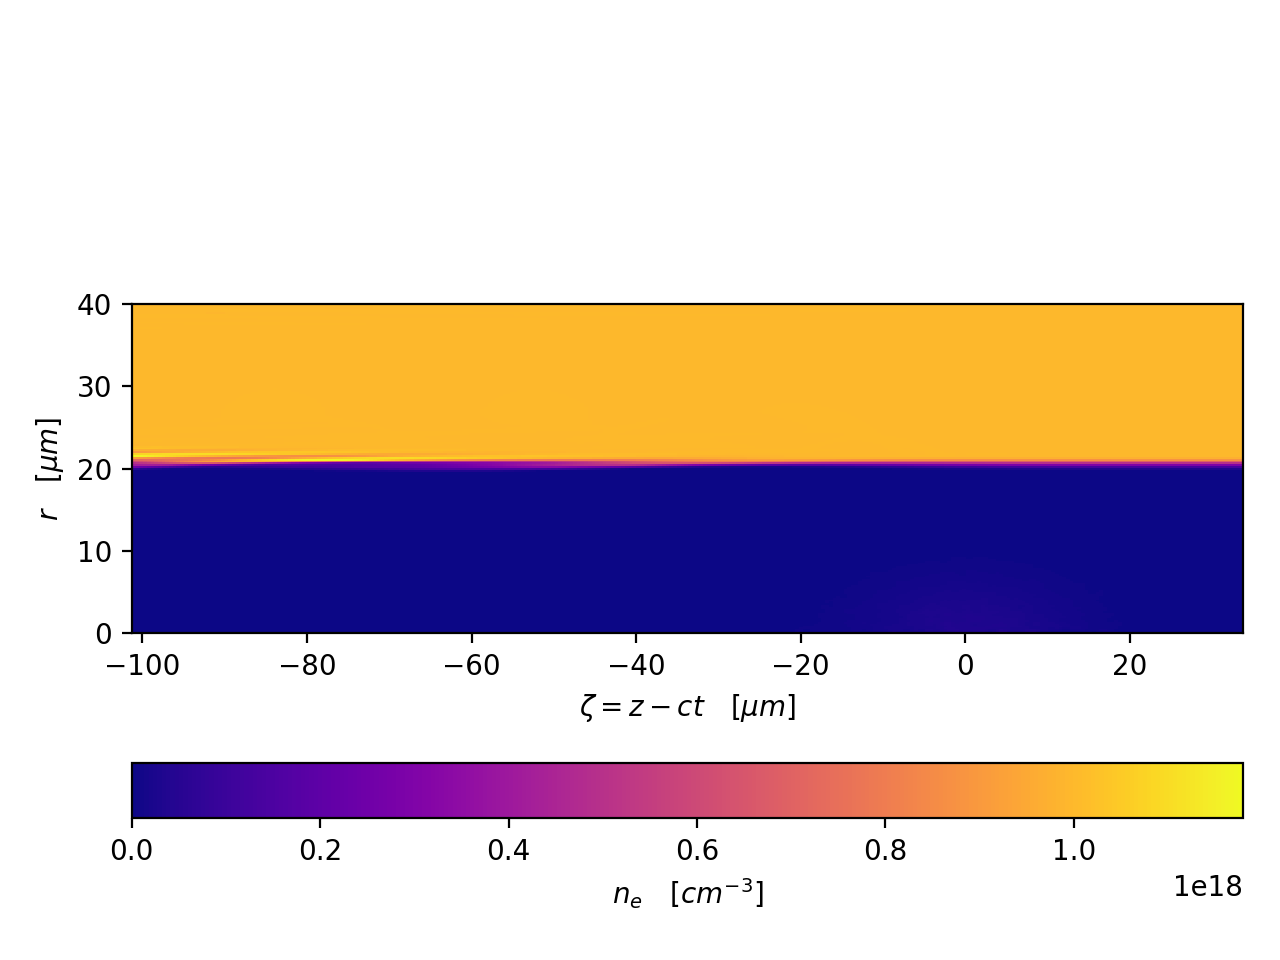

In [4]:
r = np.linspace(0., domain_radius, Nr)
zeta = np.linspace(0., domain_length, Nz)

# move zeta so zero is centered on the drive bunch
z_avg = np.average(z)
z_avg -= constants.c * dt*1300

zeta -= z_avg

zz, rr = np.meshgrid(zeta, r)

fig = plt.figure()

plt.imshow(therho,extent=[zeta[0]*1.e6,zeta[-1]*1.e6, r[0]*1.e6, r[-1]*1.e6], cmap='plasma', origin='lower')
plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$n_e \quad [cm^{-3}]$')

plt.tight_layout()

plt.savefig('rho.png')


<IPython.core.display.Javascript object>


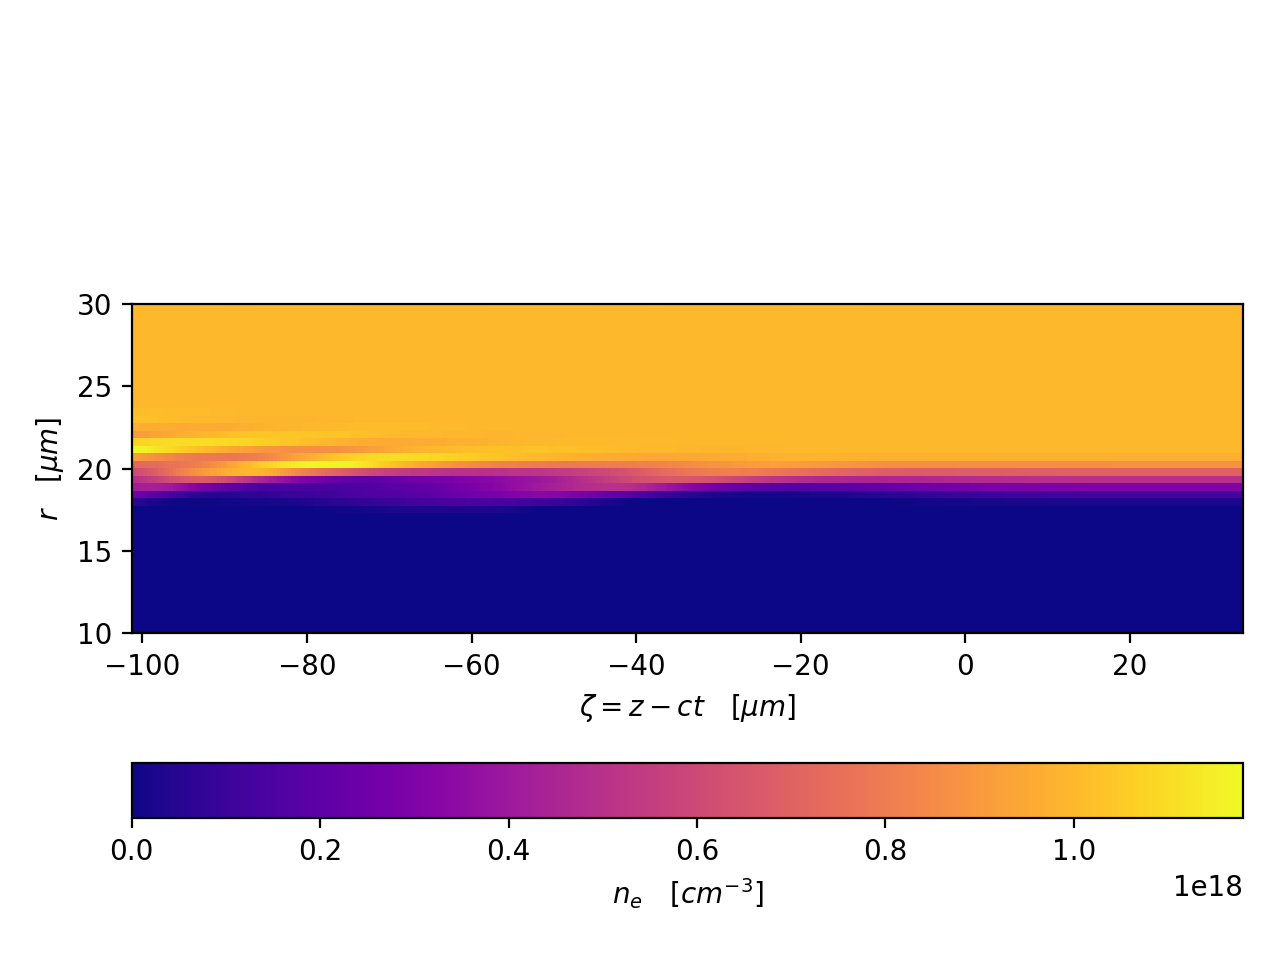

In [8]:
shape = np.shape(therho)
zoomed_min = int(shape[0]*.4)
zoomed_max = int(shape[0]*.65)
zoomedrho = therho[zoomed_min:zoomed_max,:]

fig = plt.figure()

plt.imshow(zoomedrho,extent=[zeta[0]*1.e6,zeta[-1]*1.e6, r[-1]*1.e6*.25, r[-1]*1.e6*.75], cmap='plasma', origin='lower',aspect=2)
plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$n_e \quad [cm^{-3}]$')

plt.tight_layout()

plt.savefig('zoomedrho.png')


<IPython.core.display.Javascript object>


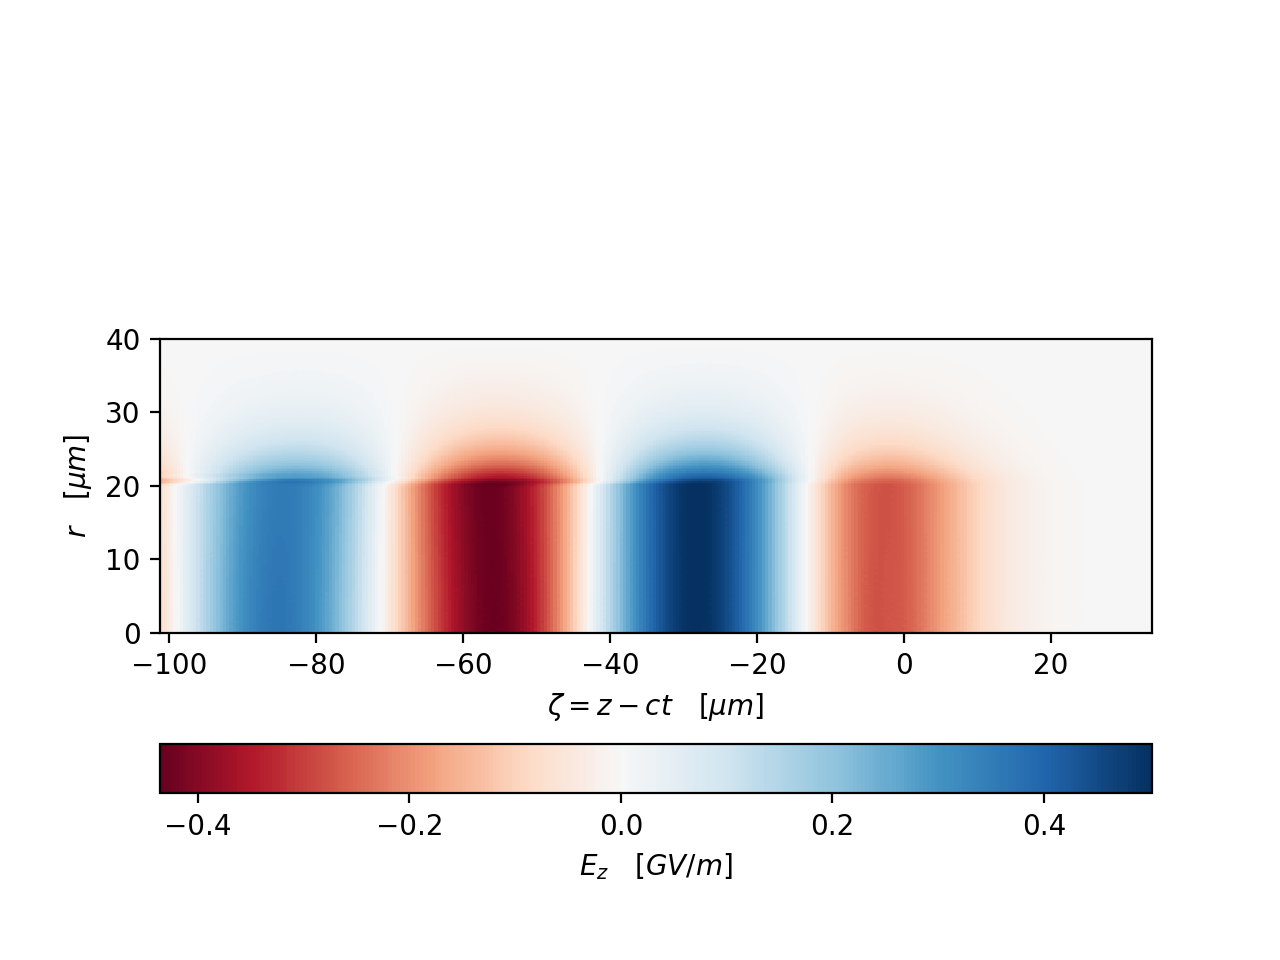

In [7]:
fig = plt.figure()

# Fix the midpoint to zero field

ezmax = np.amax(theEz)
ezmin = np.amin(theEz)
ezavg = 0.

plt.imshow(theEz,extent=[zeta[0]*1.e6, zeta[-1]*1.e6, r[0]*1.e6, r[-1]*1.e6], 
           cmap='RdBu', origin='lower', norm=MidpointNormalize(midpoint=ezavg,vmin=ezmin, vmax=ezmax))
plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$E_z \quad [GV/m]$')

plt.savefig('Ez.png')


***
## Computing the $m=0$ Impedance

Using the field data generated from the simulation above, we can compute the $m=0$ wake, which corresponds to the accelerating potential generated by the drive and witness bunches. Per the taxonomy used in Chao [ref. 4](#References), and the corresponding modes computed in [ref. 1](#References), we expect the wake functions to be given by

>$
W_{\parallel}^{(m)} = \frac{2 \kappa_m}{b^{2m}} \cos \left ( \Omega_m k_p \zeta \right ) \\
W_{\perp}^{(m)} = \frac{2 m \kappa_m}{b^{2m} \Omega_m k_p} \sin \left (\Omega_m k_p \zeta \right )
$

where

>$ \kappa_m = \frac{\omega_p^2}{c^2} \left [ \frac{K_m(k_p b)}{k_p b K_{m+1}(k_p b)} \right ] \left [ 1 + \frac{k_p b K_m(k_p b)}{2 (m+1) K_{m+1}(k_p b)} \right ]^{-1} $

and

>$ \Omega_m = \left [ \frac{(1 + \delta_{m,0}) (m+1) K_{m+1}(k_p b)}{2 (m+1) K_{m+1}(k_p b) + k_p b K_m(k_p b)} \right ]^{1/2}$

Here $K_m$ is the $m^{th}$ order modified Bessel function of the second kind. For the $m=0$ wake, this means that, for an on-axis beam, we expect to see no transverse forces and a longitudinal force that varies sinusoidally and scales with the channel radius. More specifically, we expect that the longitudinal electric field will be given by

>$ E_z(\zeta) = \int_\zeta^{\infty} d\zeta' ~W_{\parallel}^{(0)}(\zeta - \zeta') \rho(\zeta')$

and for there to be no $\vec{E}_\perp$ or $\vec{B}$ excited by the drive bunch. For our gaussian charge distribution, 

>$\rho = \frac{Q_{beam}}{\sqrt{2 \pi \sigma_z^2}} \exp [- \zeta^2/2 \sigma_z^2]$,

this means that

>$ E_z(\zeta) = \kappa_0 Q_{beam}   e^{-(\Omega_0 k_p \sigma_z)^2/2}~ \mathfrak{Re} \left ( e^{-i \Omega_0 k_p  \zeta} \textrm{Erfc} \left ( \frac{\zeta - i \Omega_0 k_p  \sigma_z^2}{\sqrt{2 }\sigma_z} \right ) + \textrm{c.c.} \right )$

This should only work for short distances, as the linear response treatment of the plasma channel will break down once the electrons sweep back into the hollow channel, as demonstrated by Lindstrom et al. [ref. 5](#References). Therefore, our benchmark will only be for short distances behind the drive bunch.

***

In [8]:
def compute_analytic_Ez(Omega0kp, sigma, Q, kappa0, zeta):
        
    phase_arg = Omega0kp * zeta
    erfc_arg  = (zeta - 1.j*Omega0kp*sigma*sigma)/(np.sqrt(2)*sigma)
        
    Ez = np.exp(-1.j*phase_arg)*(erfc(erfc_arg))
    Ez = np.real(Ez)
    Ez *= kappa0 * Q * np.exp(- 0.5 * (Omega0kp * sigma)**2)/(4*np.pi*constants.epsilon_0)
    
    return Ez

In [9]:
# Test compute_analytic_Ez with the parameters for the plasma channel above
kpb = k_p*channel_inner_radius
Omega0 = np.sqrt( 2.*k1(kpb) / ( 2*k1(kpb) + kpb*k0(kpb) ) )
kappa0 = k_p*k_p*( k0(kpb)/(kpb*k1(kpb)) ) / ( 1. + kpb*k0(kpb) / (2.*k1(kpb)) )

sigma = drive_sigma_z
Omega0kp = Omega0*k_p
Q = drive_Q

print 'Omega0 =', Omega0
print 'k_p x b =', kpb

Omega0 = 0.6118044943423983
k_p x b = 3.763577152419073


<IPython.core.display.Javascript object>


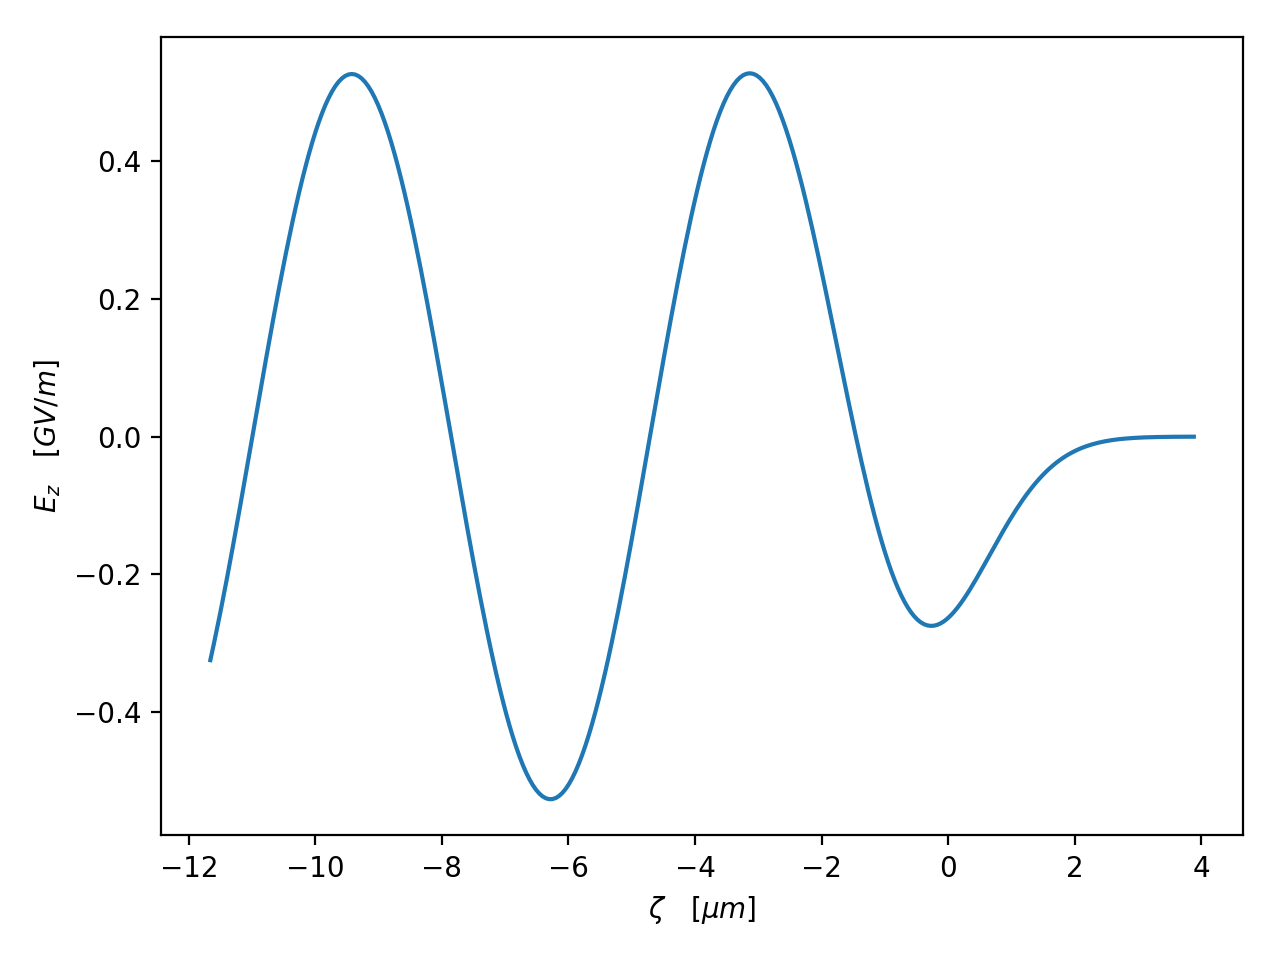

In [10]:
thePhase = Omega0kp*zeta

my_Ez = compute_analytic_Ez(Omega0kp, sigma, Q, kappa0, zeta)
fig = plt.figure()
plt.plot(thePhase, my_Ez*1.e-9)
plt.xlabel(r'$\zeta \quad [\mu m]$')
plt.ylabel(r'$E_z \quad [GV/m]$')
plt.tight_layout()

<IPython.core.display.Javascript object>


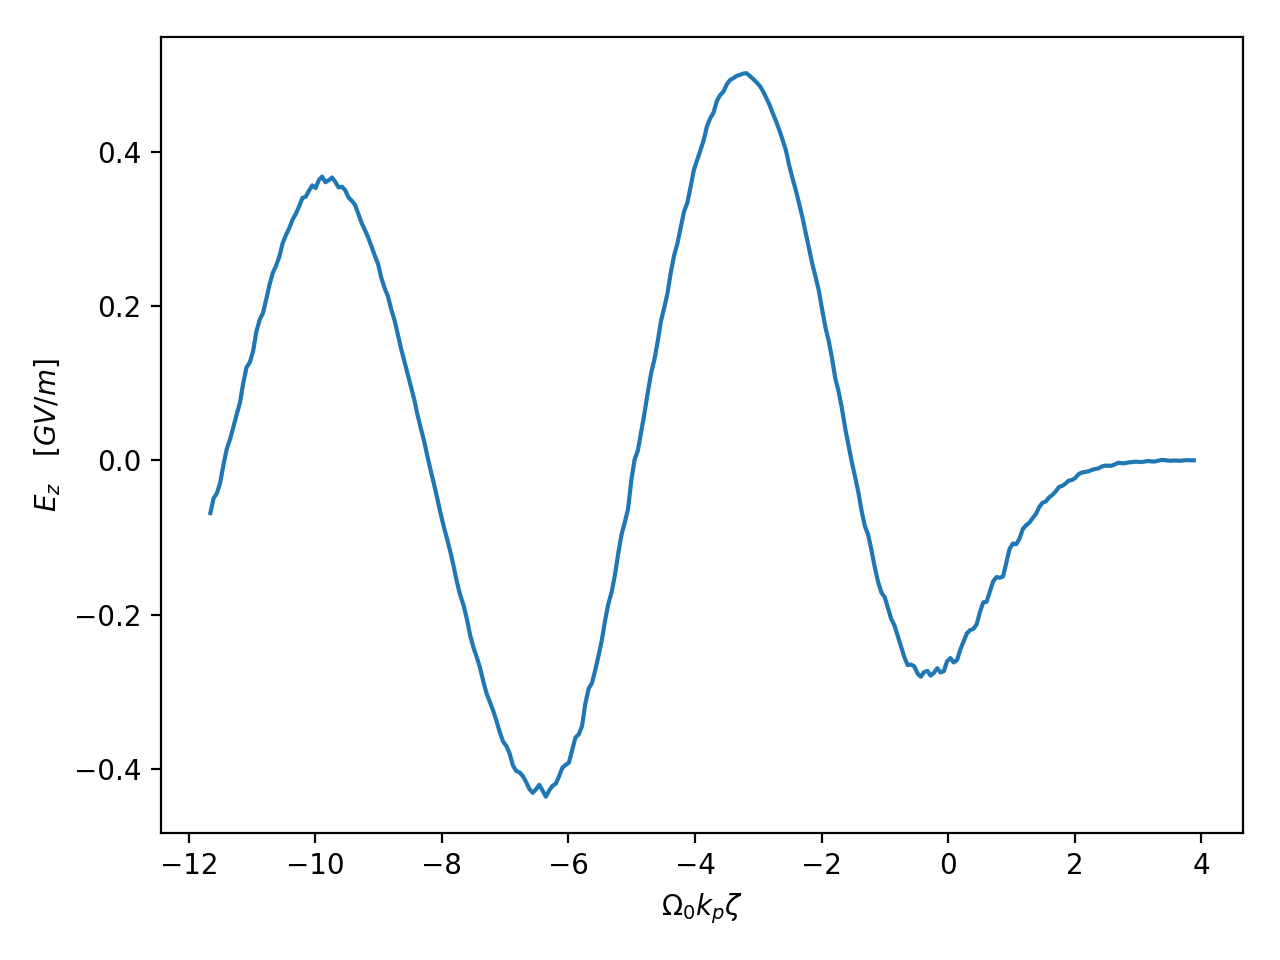

In [11]:
fig = plt.figure()
plt.plot(thePhase, theEz[0,:])
plt.xlabel(r'$\Omega_0 k_p \zeta$')
plt.ylabel(r'$E_z \quad [GV/m]$')
plt.tight_layout()

<IPython.core.display.Javascript object>


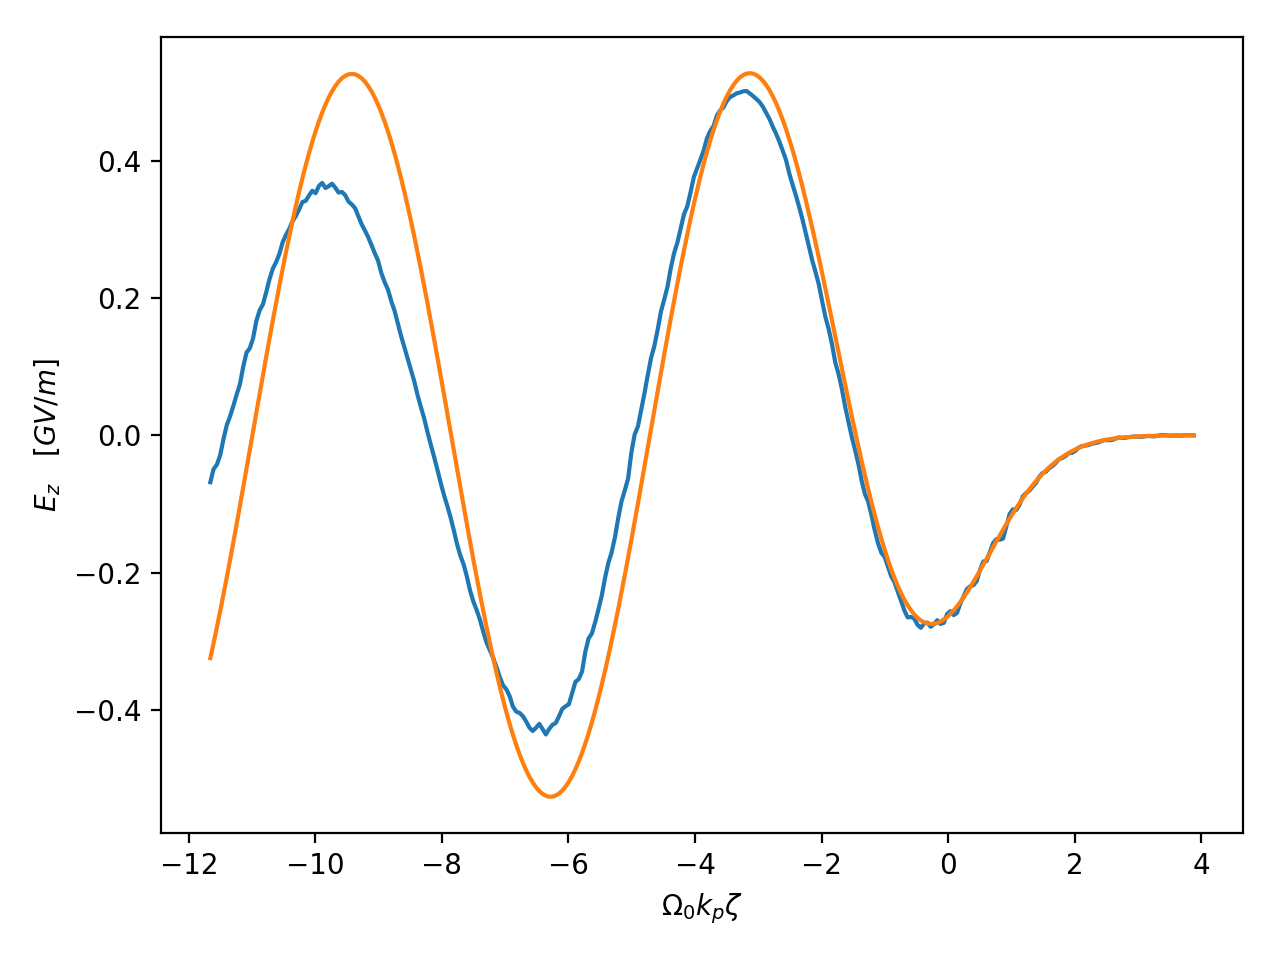

In [12]:
fig = plt.figure()

plt.plot(Omega0kp * zeta, theEz[0,:])
plt.plot(Omega0kp * zeta, my_Ez*1.e-9)
plt.xlabel(r'$\Omega_0 k_p \zeta$')
plt.ylabel(r'$E_z \quad [GV/m]$')
plt.tight_layout()

plt.savefig('analytic_vs_fbpic.png')

<IPython.core.display.Javascript object>


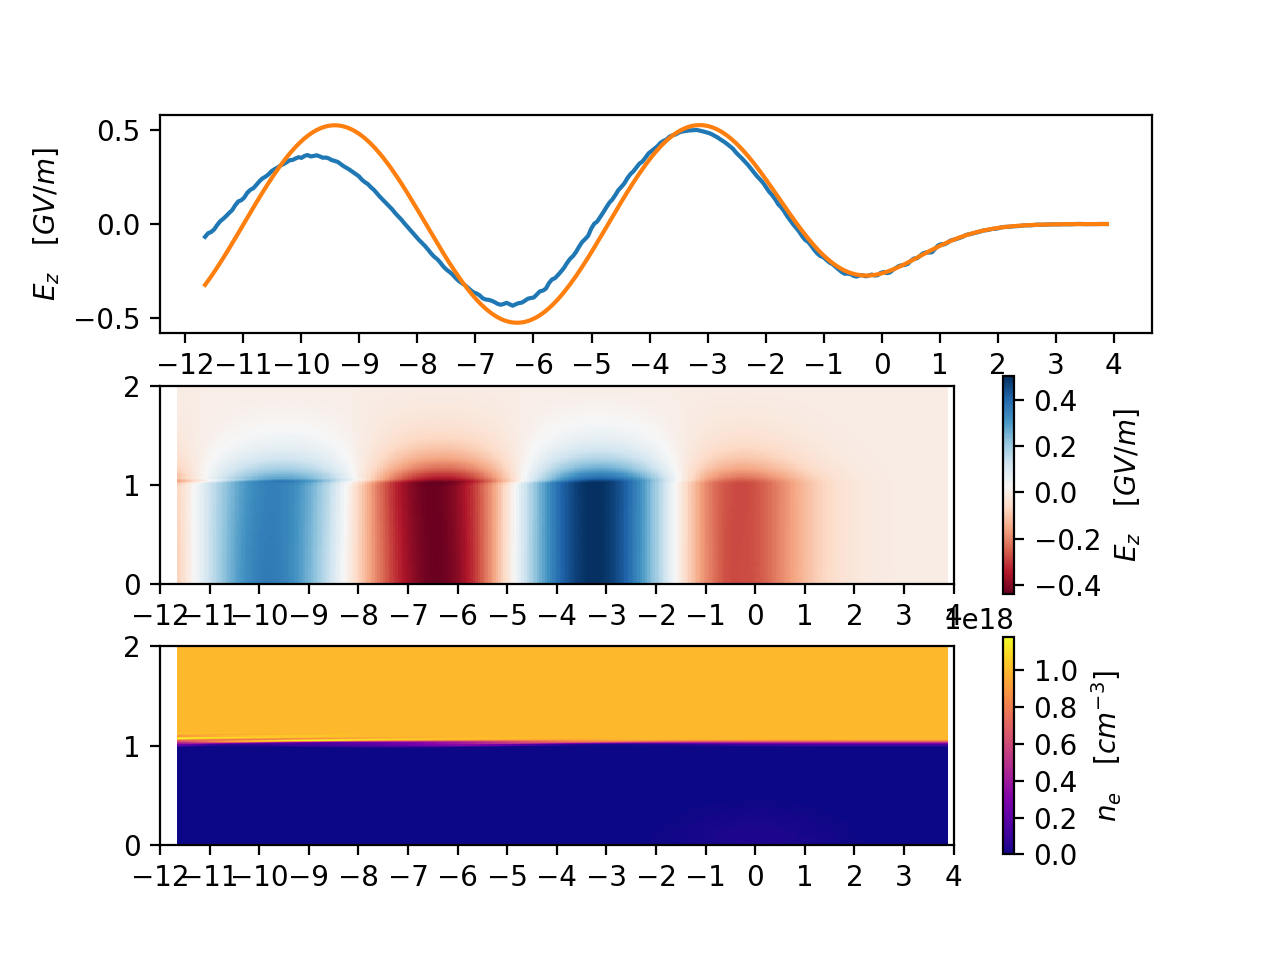

In [13]:
fig = plt.figure()


plt.subplot(3,1,1)
plt.plot(Omega0kp * zeta, theEz[0,:])
plt.plot(Omega0kp * zeta, my_Ez*1.e-9)
plt.ylabel(r'$E_z \quad [GV/m]$')
plt.xticks(np.linspace(-12,4,17))


plt.subplot(3,1,2)
plt.imshow(theEz,
           extent=[Omega0kp * zeta[0], Omega0kp * zeta[-1], r[0]/channel_inner_radius, r[-1]/channel_inner_radius], 
           cmap='RdBu', origin='lower', aspect=2)
#plt.ylabel(r'$r \quad [\mu m]$')
plt.xticks(np.linspace(-12,4,17))
cbar = plt.colorbar()
cbar.set_label(r'$E_z \quad [GV/m]$')

plt.subplot(3,1,3)
plt.imshow(therho,
            extent=[Omega0kp * zeta[0],Omega0kp * zeta[-1], r[0]/channel_inner_radius, r[-1]/channel_inner_radius],
            cmap='plasma', origin='lower', aspect=2)
plt.xticks(np.linspace(-12,4,17))
cbar = plt.colorbar()
cbar.set_label(r'$n_e \quad [cm^{-3}]$')

***
## References

> 1. C. B. Schroeder, D. H. Whittum, and J. S. Wurtele, "Multimode Analysis of the Hollow Plasma Channel Wakefield Accelerator", _Phys. Rev. Lett._ __82__, 1177 (1999). [https://doi.org/10.1103/PhysRevLett.82.1177](https://doi.org/10.1103/PhysRevLett.82.1177)

> 2. R. Lehe, M. Kirchen, I. A. Andriyash, B. B. Godfrey, and J.-L. Vay, "A spectral, quasi-cylindrical and dispersion-free Particle-In-Cell algorithm", _Comp. Phys. Comm._ __203__, pp. 66-82 (2016). [https://doi.org/10.1016/j.cpc.2016.02.007](https://doi.org/10.1016/j.cpc.2016.02.007)

> 3. C. Joshi _et al._ "Plasma wakefield acceleration experiments at FACET II", _Plasma Phys. Control. Fusion_ __60__, 3 (2018).

> 4. A. W. Chao, "Physics of Collective Beam Instabilities in High Energy Accelerators", John Wiley & Sons (1993)

> 5. C. A. Lindstrom _et al._ "Measurement of Transverse Wakefields Induced by a Misaligned Positron Bunch in a Hollow Channel Plasma Accelerator", _Phys. Rev. Lett._ __120__, 124802 (2018).